In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
%matplotlib notebook
import copy
import csv
import glob

In [2]:
FeP_CO = './CO-FeP-8014.csv'
FeP_CO = (pd.read_csv(FeP_CO)).values
data_sets = FeP_CO[:,1:]
print(data_sets.shape,'\n'
      ,data_sets[0,27]
     )
bad_data_set = np.where(data_sets[:,:27]<0)[0]
bad_data_set = np.unique(bad_data_set)
data_sets = np.delete(data_sets,bad_data_set,axis=0)  #删除描述符小于0的样本
print(data_sets.shape,data_sets[0,:])

(8014, 32) 
 34.3839
(7822, 32) [ 0.00000000e+00  7.97749000e+01  7.88000000e-02  5.70100000e-01
  9.12968000e+01  7.80000000e-02  6.02900000e-01  1.90057800e+02
  3.27700000e-01  1.73490000e+00  3.26569200e+02  3.66810000e+00
  1.49500000e-01  3.48180800e+02  3.20490000e+00  1.58600000e-01
  5.05609800e+02  1.39000000e+00  1.62300000e-01  5.35343700e+02
  2.05100000e+00  2.36900000e-01  6.24982200e+02  2.10889000e+01
  2.31570000e+00  2.06517650e+03  6.14578600e+02  3.43839000e+01
 -1.23606292e+01  1.68108900e+00  1.16001000e+00  1.77715561e+02]


In [3]:
x = data_sets[:,1:28]
y_uncomp = data_sets[:,29]
standar_scaler = preprocessing.StandardScaler()                 # 特征数据标准化
x = standar_scaler.fit_transform(x)
print(x[0,:])
scaler = preprocessing.StandardScaler().fit(y_uncomp.reshape(-1,1))#标准化到,scaler保存方差和均值,
y_scaled = preprocessing.scale(y_uncomp.reshape(-1,1))#下次标准化，按scaler2标准化到（mean_=0，var_=1）
y_inver = scaler.inverse_transform(y_scaled)#按scaler2回到原来参数

print(y_uncomp.shape,y_uncomp[:3],'\n','\n'
      ,y_scaled.shape,y_scaled[:3],'\n','\n'
      ,y_inver.shape,y_inver[:3]
     )
data_sets = np.hstack((x,y_scaled))
print(data_sets.shape,data_sets[0,:])

#用固定随机种子打乱二维数组的行顺序
np.random.seed(1)
np.random.shuffle(data_sets)
print(data_sets[0,27])

[-1.30975296  0.83959228  0.12987748 -1.29166525  0.77763446  0.87257407
  0.15253913 -0.46747913 -0.25814035  0.4059082   0.70786827  0.60641935
 -0.04454691 -0.00861144  0.68411636 -1.16957303 -0.57673754 -1.20299624
 -0.78940209 -0.25933814 -0.48590257  0.11753195  0.36320457  0.81970798
  1.35058235  0.84635312  0.14478589]
(7822,) [1.681089 1.718343 1.747899] 
 
 (7822, 1) [[-0.578478  ]
 [ 0.63273689]
 [ 1.59367176]] 
 
 (7822, 1) [[1.681089]
 [1.718343]
 [1.747899]]
(7822, 28) [-1.30975296  0.83959228  0.12987748 -1.29166525  0.77763446  0.87257407
  0.15253913 -0.46747913 -0.25814035  0.4059082   0.70786827  0.60641935
 -0.04454691 -0.00861144  0.68411636 -1.16957303 -0.57673754 -1.20299624
 -0.78940209 -0.25933814 -0.48590257  0.11753195  0.36320457  0.81970798
  1.35058235  0.84635312  0.14478589 -0.578478  ]
-0.3349280285180307


In [4]:
k_fold = 5
one_fold = int(data_sets.shape[0]/k_fold)
redundant = data_sets.shape[0] - one_fold*k_fold
print(one_fold,'       ',redundant)
data_sets_1 = data_sets[0:1565,:]
data_sets_2 = data_sets[1565:3130,:]
data_sets_3 = data_sets[3130:4694,:]
data_sets_4 = data_sets[4694:6258,:]
data_sets_5 = data_sets[6258:7822,:]
print(data_sets_1.shape,data_sets_2.shape,data_sets_3.shape,data_sets_4.shape,data_sets_5.shape)

data_sets_new = np.vstack((data_sets_1,data_sets_2))
data_sets_new = np.vstack((data_sets_new,data_sets_3))
data_sets_new = np.vstack((data_sets_new,data_sets_4))
data_sets_new = np.vstack((data_sets_new,data_sets_5))

print((data_sets == data_sets_new).all())
data_sets_train = np.vstack((data_sets_2,data_sets_3))
data_sets_train = np.vstack((data_sets_train,data_sets_4))
data_sets_train = np.vstack((data_sets_train,data_sets_5))
data_sets_test  = data_sets_1
print(data_sets_train.shape,data_sets_test.shape)
x_train = data_sets_train[:,:-1]
y_train = data_sets_train[:,-1]
x_test = data_sets_test[:,:-1]
y_test = data_sets_test[:,-1]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

1564         2
(1565, 28) (1565, 28) (1564, 28) (1564, 28) (1564, 28)
True
(6257, 28) (1565, 28)
(6257, 27) (6257,) (1565, 27) (1565,)


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,input_shape=(x_train.shape[1],),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.03)),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
#     tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.05),
#     tf.keras.layers.Dense(8, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),
#     #tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(256, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(32, activation='relu'),
#     #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,953
Trainable params: 13,953
Non-trainable params: 0
_________________________________________________________________


In [6]:
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.1, decay_steps=80, decay_rate=0.98) #好的效果参数：0.1，80，0.98
model.compile(optimizer=tf.keras.optimizers.Adam(exponential_decay),
              loss='mse',
#               metrics=['acc', 'lr']
             )
print(int(y_train.shape[0]/2+1))

3129


In [7]:
checkpoint_save_path = "./Fe-C-O/Fe-C-O.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('- - - - - - - - - - - -load the model- - - - - - - - - - - -')
    model.load_weights(checkpoint_save_path)

In [8]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_weights_only=True,
                                                save_best_only=True)

In [9]:
history = model.fit(x_train, y_train, batch_size=y_train.shape[0], epochs=5000, 
                    validation_data=(x_test, y_test), 
                    validation_freq=1,
                    callbacks=[cp_callback]
                   )

Epoch 1/5000
1/1 [==============================] - 5s 5s/step - loss: 4.4787 - val_loss: 252.3514
Epoch 2/5000
1/1 [==============================] - 0s 83ms/step - loss: 241.1025 - val_loss: 86.9842
Epoch 3/5000
1/1 [==============================] - 0s 95ms/step - loss: 84.5128 - val_loss: 7.2127
Epoch 4/5000
1/1 [==============================] - 0s 70ms/step - loss: 7.1156 - val_loss: 17.8231
Epoch 5/5000
1/1 [==============================] - 0s 83ms/step - loss: 17.4790 - val_loss: 11.8659
Epoch 6/5000
1/1 [==============================] - 0s 93ms/step - loss: 11.7675 - val_loss: 11.9151
Epoch 7/5000
1/1 [==============================] - 0s 93ms/step - loss: 11.8972 - val_loss: 13.6567
Epoch 8/5000
1/1 [==============================] - 0s 98ms/step - loss: 13.6498 - val_loss: 18.0352
Epoch 9/5000
1/1 [==============================] - 0s 99ms/step - loss: 17.9390 - val_loss: 17.3326
Epoch 10/5000
1/1 [==============================] - 0s 72ms/step - loss: 17.3405 - val_loss: 

1/1 [==============================] - 0s 81ms/step - loss: 7.4422 - val_loss: 7.2868
Epoch 82/5000
1/1 [==============================] - 0s 86ms/step - loss: 7.3039 - val_loss: 7.1434
Epoch 83/5000
1/1 [==============================] - 0s 122ms/step - loss: 7.1611 - val_loss: 6.9986
Epoch 84/5000
1/1 [==============================] - 0s 106ms/step - loss: 7.0169 - val_loss: 6.8541
Epoch 85/5000
1/1 [==============================] - 0s 79ms/step - loss: 6.8728 - val_loss: 6.7092
Epoch 86/5000
1/1 [==============================] - 0s 105ms/step - loss: 6.7280 - val_loss: 6.5654
Epoch 87/5000
1/1 [==============================] - 0s 98ms/step - loss: 6.5842 - val_loss: 6.4241
Epoch 88/5000
1/1 [==============================] - 0s 80ms/step - loss: 6.4430 - val_loss: 6.2860
Epoch 89/5000
1/1 [==============================] - 0s 79ms/step - loss: 6.3052 - val_loss: 6.1512
Epoch 90/5000
1/1 [==============================] - 0s 84ms/step - loss: 6.1710 - val_loss: 6.0201
Epoch 91/50

1/1 [==============================] - 0s 81ms/step - loss: 1.8746 - val_loss: 1.8491
Epoch 163/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.8491 - val_loss: 1.8240
Epoch 164/5000
1/1 [==============================] - 0s 67ms/step - loss: 1.8241 - val_loss: 1.7993
Epoch 165/5000
1/1 [==============================] - 0s 66ms/step - loss: 1.7995 - val_loss: 1.7754
Epoch 166/5000
1/1 [==============================] - 0s 98ms/step - loss: 1.7756 - val_loss: 1.7518
Epoch 167/5000
1/1 [==============================] - 0s 90ms/step - loss: 1.7521 - val_loss: 1.7284
Epoch 168/5000
1/1 [==============================] - 0s 98ms/step - loss: 1.7289 - val_loss: 1.7056
Epoch 169/5000
1/1 [==============================] - 0s 107ms/step - loss: 1.7063 - val_loss: 1.6833
Epoch 170/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.6841 - val_loss: 1.6615
Epoch 171/5000
1/1 [==============================] - 0s 105ms/step - loss: 1.6623 - val_loss: 1.6402
Epo

Epoch 243/5000
1/1 [==============================] - 0s 113ms/step - loss: 0.7822 - val_loss: 0.7758
Epoch 244/5000
1/1 [==============================] - 0s 124ms/step - loss: 0.7764 - val_loss: 0.7708
Epoch 245/5000
1/1 [==============================] - 0s 201ms/step - loss: 0.7712 - val_loss: 0.7648
Epoch 246/5000
1/1 [==============================] - 0s 138ms/step - loss: 0.7656 - val_loss: 0.7577
Epoch 247/5000
1/1 [==============================] - 0s 91ms/step - loss: 0.7581 - val_loss: 0.7495
Epoch 248/5000
1/1 [==============================] - 0s 110ms/step - loss: 0.7501 - val_loss: 0.7434
Epoch 249/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.7440 - val_loss: 0.7389
Epoch 250/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.7393 - val_loss: 0.7329
Epoch 251/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.7336 - val_loss: 0.7260
Epoch 252/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.7266 - va

Epoch 324/5000
1/1 [==============================] - 0s 122ms/step - loss: 0.4470 - val_loss: 0.4447
Epoch 325/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.4453 - val_loss: 0.4436
Epoch 326/5000
1/1 [==============================] - 0s 106ms/step - loss: 0.4438 - val_loss: 0.4420
Epoch 327/5000
1/1 [==============================] - 0s 117ms/step - loss: 0.4426 - val_loss: 0.4415
Epoch 328/5000
1/1 [==============================] - 0s 127ms/step - loss: 0.4416 - val_loss: 0.4396
Epoch 329/5000
1/1 [==============================] - 0s 176ms/step - loss: 0.4402 - val_loss: 0.4378
Epoch 330/5000
1/1 [==============================] - 0s 145ms/step - loss: 0.4379 - val_loss: 0.4335
Epoch 331/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.4340 - val_loss: 0.4288
Epoch 332/5000
1/1 [==============================] - 0s 91ms/step - loss: 0.4290 - val_loss: 0.4238
Epoch 333/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.4243 - v

Epoch 405/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.3005 - val_loss: 0.2994
Epoch 406/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.2996 - val_loss: 0.2987
Epoch 407/5000
1/1 [==============================] - 0s 103ms/step - loss: 0.2987 - val_loss: 0.2970
Epoch 408/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.2973 - val_loss: 0.2954
Epoch 409/5000
1/1 [==============================] - 0s 103ms/step - loss: 0.2955 - val_loss: 0.2941
Epoch 410/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.2942 - val_loss: 0.2931
Epoch 411/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.2933 - val_loss: 0.2922
Epoch 412/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.2923 - val_loss: 0.2908
Epoch 413/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.2910 - val_loss: 0.2894
Epoch 414/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.2895 - val_l

Epoch 486/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.2225 - val_loss: 0.2217
Epoch 487/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.2219 - val_loss: 0.2213
Epoch 488/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.2213 - val_loss: 0.2206
Epoch 489/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.2208 - val_loss: 0.2203
Epoch 490/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.2203 - val_loss: 0.2197
Epoch 491/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.2199 - val_loss: 0.2198
Epoch 492/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.2197 - val_loss: 0.2196
Epoch 493/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.2199 - val_loss: 0.2206
Epoch 494/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.2205 - val_loss: 0.2215
Epoch 495/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.2219 - val_los

Epoch 567/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.1734 - val_loss: 0.1742
Epoch 568/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.1741 - val_loss: 0.1744
Epoch 569/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.1746 - val_loss: 0.1744
Epoch 570/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.1743 - val_loss: 0.1729
Epoch 571/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.1731 - val_loss: 0.1716
Epoch 572/5000
1/1 [==============================] - 0s 120ms/step - loss: 0.1716 - val_loss: 0.1702
Epoch 573/5000
1/1 [==============================] - 0s 113ms/step - loss: 0.1703 - val_loss: 0.1695
Epoch 574/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.1696 - val_loss: 0.1693
Epoch 575/5000
1/1 [==============================] - 0s 111ms/step - loss: 0.1694 - val_loss: 0.1693
Epoch 576/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.1694 - val

Epoch 648/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.1401 - val_loss: 0.1398
Epoch 649/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.1399 - val_loss: 0.1396
Epoch 650/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.1396 - val_loss: 0.1390
Epoch 651/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.1391 - val_loss: 0.1385
Epoch 652/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.1386 - val_loss: 0.1382
Epoch 653/5000
1/1 [==============================] - 0s 91ms/step - loss: 0.1382 - val_loss: 0.1378
Epoch 654/5000
1/1 [==============================] - 0s 132ms/step - loss: 0.1379 - val_loss: 0.1377
Epoch 655/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.1377 - val_loss: 0.1373
Epoch 656/5000
1/1 [==============================] - 0s 163ms/step - loss: 0.1374 - val_loss: 0.1370
Epoch 657/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.1370 - val_

Epoch 729/5000
1/1 [==============================] - 0s 98ms/step - loss: 0.1174 - val_loss: 0.1169
Epoch 730/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.1170 - val_loss: 0.1174
Epoch 731/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.1175 - val_loss: 0.1166
Epoch 732/5000
1/1 [==============================] - 0s 115ms/step - loss: 0.1166 - val_loss: 0.1161
Epoch 733/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.1161 - val_loss: 0.1163
Epoch 734/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.1164 - val_loss: 0.1158
Epoch 735/5000
1/1 [==============================] - 0s 103ms/step - loss: 0.1157 - val_loss: 0.1153
Epoch 736/5000
1/1 [==============================] - 0s 202ms/step - loss: 0.1153 - val_loss: 0.1152
Epoch 737/5000
1/1 [==============================] - 0s 108ms/step - loss: 0.1153 - val_loss: 0.1149
Epoch 738/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.1149 - val

1/1 [==============================] - 0s 109ms/step - loss: 0.0990 - val_loss: 0.0988
Epoch 810/5000
1/1 [==============================] - 0s 128ms/step - loss: 0.0988 - val_loss: 0.0987
Epoch 811/5000
1/1 [==============================] - 0s 126ms/step - loss: 0.0987 - val_loss: 0.0985
Epoch 812/5000
1/1 [==============================] - 0s 134ms/step - loss: 0.0986 - val_loss: 0.0987
Epoch 813/5000
1/1 [==============================] - 0s 163ms/step - loss: 0.0986 - val_loss: 0.0987
Epoch 814/5000
1/1 [==============================] - 0s 132ms/step - loss: 0.0989 - val_loss: 0.0997
Epoch 815/5000
1/1 [==============================] - 0s 105ms/step - loss: 0.0996 - val_loss: 0.1008
Epoch 816/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.1011 - val_loss: 0.1047
Epoch 817/5000
1/1 [==============================] - 0s 101ms/step - loss: 0.1044 - val_loss: 0.1108
Epoch 818/5000
1/1 [==============================] - 0s 94ms/step - loss: 0.1114 - val_loss: 0.12

Epoch 890/5000
1/1 [==============================] - 0s 138ms/step - loss: 0.0864 - val_loss: 0.0863
Epoch 891/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0863 - val_loss: 0.0861
Epoch 892/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0861 - val_loss: 0.0860
Epoch 893/5000
1/1 [==============================] - 0s 105ms/step - loss: 0.0860 - val_loss: 0.0858
Epoch 894/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0858 - val_loss: 0.0856
Epoch 895/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.0857 - val_loss: 0.0855
Epoch 896/5000
1/1 [==============================] - 0s 122ms/step - loss: 0.0855 - val_loss: 0.0854
Epoch 897/5000
1/1 [==============================] - 0s 128ms/step - loss: 0.0854 - val_loss: 0.0852
Epoch 898/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0852 - val_loss: 0.0851
Epoch 899/5000
1/1 [==============================] - 0s 110ms/step - loss: 0.0851 - v

1/1 [==============================] - 0s 70ms/step - loss: 0.0841 - val_loss: 0.0863
Epoch 971/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0867 - val_loss: 0.1083
Epoch 972/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.1078 - val_loss: 0.0868
Epoch 973/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0871 - val_loss: 0.0803
Epoch 974/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0804 - val_loss: 0.0980
Epoch 975/5000
1/1 [==============================] - 0s 113ms/step - loss: 0.0975 - val_loss: 0.0845
Epoch 976/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0848 - val_loss: 0.0790
Epoch 977/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0791 - val_loss: 0.0919
Epoch 978/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0915 - val_loss: 0.0817
Epoch 979/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0820 - val_loss: 0.0787
Epo

1/1 [==============================] - 0s 95ms/step - loss: 0.0691 - val_loss: 0.0691
Epoch 1051/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0691 - val_loss: 0.0690
Epoch 1052/5000
1/1 [==============================] - 0s 140ms/step - loss: 0.0690 - val_loss: 0.0689
Epoch 1053/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0689 - val_loss: 0.0688
Epoch 1054/5000
1/1 [==============================] - 0s 154ms/step - loss: 0.0688 - val_loss: 0.0687
Epoch 1055/5000
1/1 [==============================] - 0s 132ms/step - loss: 0.0687 - val_loss: 0.0686
Epoch 1056/5000
1/1 [==============================] - 0s 108ms/step - loss: 0.0686 - val_loss: 0.0686
Epoch 1057/5000
1/1 [==============================] - 0s 109ms/step - loss: 0.0685 - val_loss: 0.0685
Epoch 1058/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0684 - val_loss: 0.0684
Epoch 1059/5000
1/1 [==============================] - 0s 112ms/step - loss: 0.0684 - val_los

1/1 [==============================] - 0s 65ms/step - loss: 0.0789 - val_loss: 0.0819
Epoch 1131/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0815 - val_loss: 0.0664
Epoch 1132/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0665 - val_loss: 0.0676
Epoch 1133/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0677 - val_loss: 0.0773
Epoch 1134/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0769 - val_loss: 0.0694
Epoch 1135/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0697 - val_loss: 0.0642
Epoch 1136/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0641 - val_loss: 0.0717
Epoch 1137/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0713 - val_loss: 0.0700
Epoch 1138/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0704 - val_loss: 0.0639
Epoch 1139/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0638 - val_loss: 0.0

1/1 [==============================] - 0s 110ms/step - loss: 0.0587 - val_loss: 0.0586
Epoch 1211/5000
1/1 [==============================] - 0s 110ms/step - loss: 0.0586 - val_loss: 0.0586
Epoch 1212/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0585 - val_loss: 0.0585
Epoch 1213/5000
1/1 [==============================] - 0s 142ms/step - loss: 0.0585 - val_loss: 0.0585
Epoch 1214/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0584 - val_loss: 0.0584
Epoch 1215/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0584 - val_loss: 0.0584
Epoch 1216/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.0583 - val_loss: 0.0583
Epoch 1217/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0583 - val_loss: 0.0582
Epoch 1218/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0582 - val_loss: 0.0582
Epoch 1219/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0582 - val_loss: 

1/1 [==============================] - 0s 75ms/step - loss: 0.0563 - val_loss: 0.0578
Epoch 1291/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0580 - val_loss: 0.0575
Epoch 1292/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0573 - val_loss: 0.0559
Epoch 1293/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0559 - val_loss: 0.0566
Epoch 1294/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0568 - val_loss: 0.0572
Epoch 1295/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0570 - val_loss: 0.0558
Epoch 1296/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0558 - val_loss: 0.0558
Epoch 1297/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0560 - val_loss: 0.0567
Epoch 1298/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0565 - val_loss: 0.0557
Epoch 1299/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0558 - val_loss: 0.0

1/1 [==============================] - 0s 103ms/step - loss: 0.0521 - val_loss: 0.0521
Epoch 1371/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0521 - val_loss: 0.0521
Epoch 1372/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 1373/5000
1/1 [==============================] - 0s 109ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 1374/5000
1/1 [==============================] - 0s 109ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 1375/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0519 - val_loss: 0.0519
Epoch 1376/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0519 - val_loss: 0.0519
Epoch 1377/5000
1/1 [==============================] - 0s 107ms/step - loss: 0.0519 - val_loss: 0.0519
Epoch 1378/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0518 - val_loss: 0.0518
Epoch 1379/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0518 - val_loss:

1/1 [==============================] - 0s 77ms/step - loss: 0.0529 - val_loss: 0.0538
Epoch 1451/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0541 - val_loss: 0.0530
Epoch 1452/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0527 - val_loss: 0.0522
Epoch 1453/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0521 - val_loss: 0.0530
Epoch 1454/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0532 - val_loss: 0.0522
Epoch 1455/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0520 - val_loss: 0.0516
Epoch 1456/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0515 - val_loss: 0.0525
Epoch 1457/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0526 - val_loss: 0.0517
Epoch 1458/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0515 - val_loss: 0.0512
Epoch 1459/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0511 - val_loss: 0.0

1/1 [==============================] - 0s 100ms/step - loss: 0.0480 - val_loss: 0.0481
Epoch 1531/5000
1/1 [==============================] - 0s 112ms/step - loss: 0.0480 - val_loss: 0.0480
Epoch 1532/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0480 - val_loss: 0.0480
Epoch 1533/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.0480 - val_loss: 0.0480
Epoch 1534/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.0479 - val_loss: 0.0480
Epoch 1535/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0479 - val_loss: 0.0479
Epoch 1536/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0479 - val_loss: 0.0479
Epoch 1537/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0479 - val_loss: 0.0479
Epoch 1538/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0478 - val_loss: 0.0479
Epoch 1539/5000
1/1 [==============================] - 0s 127ms/step - loss: 0.0478 - val_loss

1/1 [==============================] - 0s 75ms/step - loss: 0.0462 - val_loss: 0.0463
Epoch 1611/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0462 - val_loss: 0.0462
Epoch 1612/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0462 - val_loss: 0.0463
Epoch 1613/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0462 - val_loss: 0.0463
Epoch 1614/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0463 - val_loss: 0.0465
Epoch 1615/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0464 - val_loss: 0.0465
Epoch 1616/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0465 - val_loss: 0.0470
Epoch 1617/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0468 - val_loss: 0.0473
Epoch 1618/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0474 - val_loss: 0.0486
Epoch 1619/5000
1/1 [==============================] - 0s 110ms/step - loss: 0.0483 - val_loss: 0.

1/1 [==============================] - 0s 127ms/step - loss: 0.0452 - val_loss: 0.0453
Epoch 1691/5000
1/1 [==============================] - 0s 103ms/step - loss: 0.0452 - val_loss: 0.0452
Epoch 1692/5000
1/1 [==============================] - 0s 130ms/step - loss: 0.0452 - val_loss: 0.0451
Epoch 1693/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0451 - val_loss: 0.0451
Epoch 1694/5000
1/1 [==============================] - 0s 101ms/step - loss: 0.0451 - val_loss: 0.0451
Epoch 1695/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0451 - val_loss: 0.0451
Epoch 1696/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0451 - val_loss: 0.0451
Epoch 1697/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0450 - val_loss: 0.0450
Epoch 1698/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0450 - val_loss: 0.0450
Epoch 1699/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0450 - val_loss:

Epoch 1770/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0440 - val_loss: 0.0442
Epoch 1771/5000
1/1 [==============================] - 0s 94ms/step - loss: 0.0442 - val_loss: 0.0444
Epoch 1772/5000
1/1 [==============================] - 0s 122ms/step - loss: 0.0443 - val_loss: 0.0446
Epoch 1773/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0446 - val_loss: 0.0451
Epoch 1774/5000
1/1 [==============================] - 0s 119ms/step - loss: 0.0450 - val_loss: 0.0456
Epoch 1775/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0456 - val_loss: 0.0467
Epoch 1776/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.0466 - val_loss: 0.0479
Epoch 1777/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0480 - val_loss: 0.0506
Epoch 1778/5000
1/1 [==============================] - 0s 111ms/step - loss: 0.0504 - val_loss: 0.0535
Epoch 1779/5000
1/1 [==============================] - 0s 102ms/step - loss: 

1/1 [==============================] - 0s 94ms/step - loss: 0.0429 - val_loss: 0.0429
Epoch 1851/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0429 - val_loss: 0.0429
Epoch 1852/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0429 - val_loss: 0.0429
Epoch 1853/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0429 - val_loss: 0.0429
Epoch 1854/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.0428 - val_loss: 0.0429
Epoch 1855/5000
1/1 [==============================] - 0s 105ms/step - loss: 0.0428 - val_loss: 0.0428
Epoch 1856/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.0428 - val_loss: 0.0429
Epoch 1857/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0428 - val_loss: 0.0428
Epoch 1858/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.0428 - val_loss: 0.0428
Epoch 1859/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0427 - val_loss:

1/1 [==============================] - 0s 73ms/step - loss: 0.0429 - val_loss: 0.0427
Epoch 1931/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0428 - val_loss: 0.0427
Epoch 1932/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0425 - val_loss: 0.0421
Epoch 1933/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0421 - val_loss: 0.0420
Epoch 1934/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0420 - val_loss: 0.0422
Epoch 1935/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0421 - val_loss: 0.0422
Epoch 1936/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0423 - val_loss: 0.0426
Epoch 1937/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0424 - val_loss: 0.0423
Epoch 1938/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0424 - val_loss: 0.0425
Epoch 1939/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0423 - val_loss: 0.0

1/1 [==============================] - 0s 74ms/step - loss: 0.0420 - val_loss: 0.0416
Epoch 2011/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0416 - val_loss: 0.0416
Epoch 2012/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0415 - val_loss: 0.0417
Epoch 2013/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0416 - val_loss: 0.0417
Epoch 2014/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0417 - val_loss: 0.0418
Epoch 2015/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 2016/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0416 - val_loss: 0.0416
Epoch 2017/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0414 - val_loss: 0.0414
Epoch 2018/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0414 - val_loss: 0.0415
Epoch 2019/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0414 - val_loss: 0.0

1/1 [==============================] - 0s 68ms/step - loss: 0.0455 - val_loss: 0.0426
Epoch 2091/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0422 - val_loss: 0.0426
Epoch 2092/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0425 - val_loss: 0.0440
Epoch 2093/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0440 - val_loss: 0.0444
Epoch 2094/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0441 - val_loss: 0.0434
Epoch 2095/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0435 - val_loss: 0.0437
Epoch 2096/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0432 - val_loss: 0.0425
Epoch 2097/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0426 - val_loss: 0.0417
Epoch 2098/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0416 - val_loss: 0.0419
Epoch 2099/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0416 - val_loss: 0.0

1/1 [==============================] - 0s 112ms/step - loss: 0.0435 - val_loss: 0.0459
Epoch 2171/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0462 - val_loss: 0.0516
Epoch 2172/5000
1/1 [==============================] - 0s 116ms/step - loss: 0.0510 - val_loss: 0.0581
Epoch 2173/5000
1/1 [==============================] - 0s 111ms/step - loss: 0.0586 - val_loss: 0.0719
Epoch 2174/5000
1/1 [==============================] - 0s 158ms/step - loss: 0.0709 - val_loss: 0.0845
Epoch 2175/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0855 - val_loss: 0.1025
Epoch 2176/5000
1/1 [==============================] - 0s 117ms/step - loss: 0.1012 - val_loss: 0.1010
Epoch 2177/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.1024 - val_loss: 0.0886
Epoch 2178/5000
1/1 [==============================] - 0s 108ms/step - loss: 0.0881 - val_loss: 0.0601
Epoch 2179/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0606 - val_los

1/1 [==============================] - 0s 94ms/step - loss: 0.0395 - val_loss: 0.0396
Epoch 2251/5000
1/1 [==============================] - 0s 106ms/step - loss: 0.0395 - val_loss: 0.0395
Epoch 2252/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0395 - val_loss: 0.0396
Epoch 2253/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0395 - val_loss: 0.0395
Epoch 2254/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0394 - val_loss: 0.0395
Epoch 2255/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0394 - val_loss: 0.0395
Epoch 2256/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0394 - val_loss: 0.0395
Epoch 2257/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0394 - val_loss: 0.0395
Epoch 2258/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0394 - val_loss: 0.0395
Epoch 2259/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0394 - val_loss: 0.

1/1 [==============================] - 0s 71ms/step - loss: 0.0531 - val_loss: 0.0562
Epoch 2331/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0567 - val_loss: 0.0611
Epoch 2332/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0601 - val_loss: 0.0604
Epoch 2333/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0612 - val_loss: 0.0626
Epoch 2334/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0622 - val_loss: 0.0606
Epoch 2335/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0611 - val_loss: 0.0568
Epoch 2336/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0569 - val_loss: 0.0478
Epoch 2337/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0479 - val_loss: 0.0402
Epoch 2338/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0401 - val_loss: 0.0402
Epoch 2339/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0401 - val_loss: 0.0

1/1 [==============================] - 0s 64ms/step - loss: 0.0385 - val_loss: 0.0386
Epoch 2411/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0386 - val_loss: 0.0389
Epoch 2412/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0387 - val_loss: 0.0388
Epoch 2413/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0388 - val_loss: 0.0393
Epoch 2414/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0391 - val_loss: 0.0394
Epoch 2415/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0394 - val_loss: 0.0403
Epoch 2416/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0400 - val_loss: 0.0408
Epoch 2417/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0409 - val_loss: 0.0428
Epoch 2418/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0424 - val_loss: 0.0443
Epoch 2419/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0445 - val_loss: 0.0

1/1 [==============================] - 0s 75ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2491/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2492/5000
1/1 [==============================] - ETA: 0s - loss: 0.037 - 0s 67ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2493/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0379 - val_loss: 0.0381
Epoch 2494/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2495/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2496/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2497/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2498/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0379 - val_loss: 0.0379
Epoch 2499/5000
1/1 [==============================] - 0s 77ms/step - loss

1/1 [==============================] - 0s 82ms/step - loss: 0.0378 - val_loss: 0.0378
Epoch 2571/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0377 - val_loss: 0.0378
Epoch 2572/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0377 - val_loss: 0.0380
Epoch 2573/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0378 - val_loss: 0.0379
Epoch 2574/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 2575/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0378 - val_loss: 0.0378
Epoch 2576/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0377 - val_loss: 0.0377
Epoch 2577/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0376 - val_loss: 0.0377
Epoch 2578/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0375 - val_loss: 0.0376
Epoch 2579/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0376 - val_loss: 0.0

1/1 [==============================] - 0s 76ms/step - loss: 0.0433 - val_loss: 0.0428
Epoch 2651/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0424 - val_loss: 0.0398
Epoch 2652/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0398 - val_loss: 0.0385
Epoch 2653/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0382 - val_loss: 0.0382
Epoch 2654/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.0381 - val_loss: 0.0388
Epoch 2655/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0387 - val_loss: 0.0393
Epoch 2656/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0391 - val_loss: 0.0391
Epoch 2657/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0392 - val_loss: 0.0394
Epoch 2658/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0390 - val_loss: 0.0385
Epoch 2659/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0385 - val_loss: 0.

Epoch 2730/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0395 - val_loss: 0.0406
Epoch 2731/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0407 - val_loss: 0.0410
Epoch 2732/5000
1/1 [==============================] - 0s 102ms/step - loss: 0.0407 - val_loss: 0.0394
Epoch 2733/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0395 - val_loss: 0.0384
Epoch 2734/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0381 - val_loss: 0.0372
Epoch 2735/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0371 - val_loss: 0.0371
Epoch 2736/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0370 - val_loss: 0.0375
Epoch 2737/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0373 - val_loss: 0.0379
Epoch 2738/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0378 - val_loss: 0.0385
Epoch 2739/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.038

1/1 [==============================] - 0s 64ms/step - loss: 0.0376 - val_loss: 0.0373
Epoch 2811/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0373 - val_loss: 0.0372
Epoch 2812/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0369 - val_loss: 0.0366
Epoch 2813/5000
1/1 [==============================] - 0s 107ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 2814/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.0363 - val_loss: 0.0365
Epoch 2815/5000
1/1 [==============================] - 0s 98ms/step - loss: 0.0364 - val_loss: 0.0366
Epoch 2816/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0366 - val_loss: 0.0370
Epoch 2817/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0368 - val_loss: 0.0369
Epoch 2818/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0369 - val_loss: 0.0372
Epoch 2819/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0369 - val_loss: 0

1/1 [==============================] - 0s 81ms/step - loss: 0.0361 - val_loss: 0.0363
Epoch 2891/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0362 - val_loss: 0.0365
Epoch 2892/5000
1/1 [==============================] - 0s 105ms/step - loss: 0.0363 - val_loss: 0.0363
Epoch 2893/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0363 - val_loss: 0.0365
Epoch 2894/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0363 - val_loss: 0.0362
Epoch 2895/5000
1/1 [==============================] - 0s 111ms/step - loss: 0.0362 - val_loss: 0.0363
Epoch 2896/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0361 - val_loss: 0.0361
Epoch 2897/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0360 - val_loss: 0.0361
Epoch 2898/5000
1/1 [==============================] - 0s 94ms/step - loss: 0.0360 - val_loss: 0.0360
Epoch 2899/5000
1/1 [==============================] - 0s 101ms/step - loss: 0.0359 - val_loss: 

1/1 [==============================] - 0s 77ms/step - loss: 0.0357 - val_loss: 0.0358
Epoch 2971/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 2972/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 2973/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 2974/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 2975/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0356 - val_loss: 0.0358
Epoch 2976/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 2977/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.0356 - val_loss: 0.0358
Epoch 2978/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 2979/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0356 - val_loss: 0.0

1/1 [==============================] - 0s 70ms/step - loss: 0.0353 - val_loss: 0.0355
Epoch 3051/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0353 - val_loss: 0.0354
Epoch 3052/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0353 - val_loss: 0.0355
Epoch 3053/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0353 - val_loss: 0.0354
Epoch 3054/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0353 - val_loss: 0.0355
Epoch 3055/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0353 - val_loss: 0.0354
Epoch 3056/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0353 - val_loss: 0.0355
Epoch 3057/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0353 - val_loss: 0.0354
Epoch 3058/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0353 - val_loss: 0.0355
Epoch 3059/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.0353 - val_loss: 0.0

1/1 [==============================] - 0s 67ms/step - loss: 0.0351 - val_loss: 0.0351
Epoch 3131/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0350 - val_loss: 0.0352
Epoch 3132/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0350 - val_loss: 0.0351
Epoch 3133/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0350 - val_loss: 0.0352
Epoch 3134/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0350 - val_loss: 0.0352
Epoch 3135/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0350 - val_loss: 0.0351
Epoch 3136/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0350 - val_loss: 0.0352
Epoch 3137/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0350 - val_loss: 0.0351
Epoch 3138/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0350 - val_loss: 0.0352
Epoch 3139/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0350 - val_loss: 0.0

1/1 [==============================] - 0s 71ms/step - loss: 0.0347 - val_loss: 0.0350
Epoch 3211/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0349 - val_loss: 0.0354
Epoch 3212/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0351 - val_loss: 0.0352
Epoch 3213/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0352 - val_loss: 0.0353
Epoch 3214/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0350 - val_loss: 0.0349
Epoch 3215/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0348 - val_loss: 0.0349
Epoch 3216/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0347 - val_loss: 0.0349
Epoch 3217/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0347 - val_loss: 0.0349
Epoch 3218/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0348 - val_loss: 0.0352
Epoch 3219/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0349 - val_loss: 0.0

1/1 [==============================] - 0s 86ms/step - loss: 0.0401 - val_loss: 0.0424
Epoch 3291/5000
1/1 [==============================] - 0s 122ms/step - loss: 0.0417 - val_loss: 0.0432
Epoch 3292/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.0434 - val_loss: 0.0461
Epoch 3293/5000
1/1 [==============================] - 0s 110ms/step - loss: 0.0455 - val_loss: 0.0471
Epoch 3294/5000
1/1 [==============================] - 0s 105ms/step - loss: 0.0473 - val_loss: 0.0491
Epoch 3295/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0486 - val_loss: 0.0475
Epoch 3296/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0477 - val_loss: 0.0452
Epoch 3297/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0448 - val_loss: 0.0401
Epoch 3298/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0401 - val_loss: 0.0365
Epoch 3299/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0361 - val_loss: 

1/1 [==============================] - 0s 87ms/step - loss: 0.0341 - val_loss: 0.0343
Epoch 3371/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0341 - val_loss: 0.0344
Epoch 3372/5000
1/1 [==============================] - ETA: 0s - loss: 0.034 - 0s 107ms/step - loss: 0.0341 - val_loss: 0.0343
Epoch 3373/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0342 - val_loss: 0.0345
Epoch 3374/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0342 - val_loss: 0.0345
Epoch 3375/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0344 - val_loss: 0.0349
Epoch 3376/5000
1/1 [==============================] - 0s 101ms/step - loss: 0.0345 - val_loss: 0.0349
Epoch 3377/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0348 - val_loss: 0.0357
Epoch 3378/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0353 - val_loss: 0.0360
Epoch 3379/5000
1/1 [==============================] - 0s 93ms/step - lo

1/1 [==============================] - 0s 76ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3451/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3452/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3453/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3454/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3455/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3456/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3457/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3458/5000
1/1 [==============================] - 0s 103ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 3459/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0337 - val_loss: 0

1/1 [==============================] - 0s 69ms/step - loss: 0.0372 - val_loss: 0.0385
Epoch 3531/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0384 - val_loss: 0.0402
Epoch 3532/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0399 - val_loss: 0.0416
Epoch 3533/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0416 - val_loss: 0.0445
Epoch 3534/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0440 - val_loss: 0.0467
Epoch 3535/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0469 - val_loss: 0.0519
Epoch 3536/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0511 - val_loss: 0.0552
Epoch 3537/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0554 - val_loss: 0.0615
Epoch 3538/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0601 - val_loss: 0.0580
Epoch 3539/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0583 - val_loss: 0.0

1/1 [==============================] - 0s 82ms/step - loss: 0.0332 - val_loss: 0.0335
Epoch 3611/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3612/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3613/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3614/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3615/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3616/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3617/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3618/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 3619/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0332 - val_loss: 0.0

1/1 [==============================] - 0s 72ms/step - loss: 0.0336 - val_loss: 0.0350
Epoch 3691/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0346 - val_loss: 0.0349
Epoch 3692/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0348 - val_loss: 0.0342
Epoch 3693/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0339 - val_loss: 0.0334
Epoch 3694/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0331 - val_loss: 0.0335
Epoch 3695/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0333 - val_loss: 0.0343
Epoch 3696/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0339 - val_loss: 0.0342
Epoch 3697/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0341 - val_loss: 0.0339
Epoch 3698/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0336 - val_loss: 0.0334
Epoch 3699/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0331 - val_loss: 0.0

1/1 [==============================] - 0s 77ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3771/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3772/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3773/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3774/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3775/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3776/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3777/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3778/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 3779/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0327 - val_loss: 0.0

1/1 [==============================] - 0s 83ms/step - loss: 0.0416 - val_loss: 0.0352
Epoch 3851/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0350 - val_loss: 0.0342
Epoch 3852/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0340 - val_loss: 0.0386
Epoch 3853/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0380 - val_loss: 0.0386
Epoch 3854/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0386 - val_loss: 0.0353
Epoch 3855/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0348 - val_loss: 0.0334
Epoch 3856/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0332 - val_loss: 0.0359
Epoch 3857/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0359 - val_loss: 0.0374
Epoch 3858/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0367 - val_loss: 0.0340
Epoch 3859/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0339 - val_loss: 0.0

1/1 [==============================] - 0s 70ms/step - loss: 0.0323 - val_loss: 0.0325
Epoch 3931/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0323 - val_loss: 0.0325
Epoch 3932/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0323 - val_loss: 0.0325
Epoch 3933/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0323 - val_loss: 0.0325
Epoch 3934/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0323 - val_loss: 0.0325
Epoch 3935/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 3936/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 3937/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 3938/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 3939/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0322 - val_loss: 0.0

1/1 [==============================] - 0s 71ms/step - loss: 0.0320 - val_loss: 0.0322
Epoch 4011/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0320 - val_loss: 0.0323
Epoch 4012/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0321 - val_loss: 0.0323
Epoch 4013/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0321 - val_loss: 0.0324
Epoch 4014/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0321 - val_loss: 0.0323
Epoch 4015/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 4016/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0322 - val_loss: 0.0324
Epoch 4017/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0323 - val_loss: 0.0327
Epoch 4018/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0324 - val_loss: 0.0326
Epoch 4019/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0325 - val_loss: 0.0

1/1 [==============================] - 0s 89ms/step - loss: 0.0320 - val_loss: 0.0324
Epoch 4091/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0322 - val_loss: 0.0339
Epoch 4092/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0335 - val_loss: 0.0340
Epoch 4093/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0339 - val_loss: 0.0336
Epoch 4094/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0332 - val_loss: 0.0324
Epoch 4095/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0322 - val_loss: 0.0321
Epoch 4096/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0319 - val_loss: 0.0328
Epoch 4097/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0324 - val_loss: 0.0330
Epoch 4098/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0329 - val_loss: 0.0332
Epoch 4099/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0328 - val_loss: 0.0

1/1 [==============================] - 0s 71ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4171/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0315 - val_loss: 0.0318
Epoch 4172/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4173/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0315 - val_loss: 0.0318
Epoch 4174/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4175/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4176/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4177/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4178/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4179/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0315 - val_loss: 0.0

1/1 [==============================] - 0s 72ms/step - loss: 0.0318 - val_loss: 0.0319
Epoch 4251/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0316 - val_loss: 0.0317
Epoch 4252/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 4253/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0314 - val_loss: 0.0317
Epoch 4254/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0315 - val_loss: 0.0319
Epoch 4255/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0316 - val_loss: 0.0318
Epoch 4256/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0316 - val_loss: 0.0319
Epoch 4257/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0316 - val_loss: 0.0317
Epoch 4258/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0315 - val_loss: 0.0316
Epoch 4259/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0314 - val_loss: 0.0

1/1 [==============================] - 0s 70ms/step - loss: 0.0313 - val_loss: 0.0316
Epoch 4331/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0314 - val_loss: 0.0318
Epoch 4332/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0315 - val_loss: 0.0319
Epoch 4333/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0318 - val_loss: 0.0324
Epoch 4334/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0321 - val_loss: 0.0327
Epoch 4335/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0326 - val_loss: 0.0337
Epoch 4336/5000
1/1 [==============================] - 0s 94ms/step - loss: 0.0333 - val_loss: 0.0344
Epoch 4337/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0343 - val_loss: 0.0363
Epoch 4338/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0359 - val_loss: 0.0379
Epoch 4339/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0378 - val_loss: 0.0

1/1 [==============================] - 0s 109ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4411/5000
1/1 [==============================] - 0s 117ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4412/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4413/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4414/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4415/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4416/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4417/5000
1/1 [==============================] - 0s 98ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4418/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0309 - val_loss: 0.0311
Epoch 4419/5000
1/1 [==============================] - 0s 102ms/step - loss: 0.0309 - val_loss: 

1/1 [==============================] - 0s 116ms/step - loss: 0.0318 - val_loss: 0.0319
Epoch 4491/5000
1/1 [==============================] - 0s 129ms/step - loss: 0.0315 - val_loss: 0.0313
Epoch 4492/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.0311 - val_loss: 0.0311
Epoch 4493/5000
1/1 [==============================] - 0s 106ms/step - loss: 0.0308 - val_loss: 0.0309
Epoch 4494/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0307 - val_loss: 0.0310
Epoch 4495/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0308 - val_loss: 0.0313
Epoch 4496/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0310 - val_loss: 0.0313
Epoch 4497/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0312 - val_loss: 0.0317
Epoch 4498/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0313 - val_loss: 0.0314
Epoch 4499/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0313 - val_loss:

1/1 [==============================] - 0s 51ms/step - loss: 0.0312 - val_loss: 0.0308
Epoch 4571/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0306 - val_loss: 0.0309
Epoch 4572/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0307 - val_loss: 0.0316
Epoch 4573/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0313 - val_loss: 0.0318
Epoch 4574/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0317 - val_loss: 0.0319
Epoch 4575/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0315 - val_loss: 0.0313
Epoch 4576/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0311 - val_loss: 0.0309
Epoch 4577/5000
1/1 [==============================] - ETA: 0s - loss: 0.030 - 0s 50ms/step - loss: 0.0306 - val_loss: 0.0308
Epoch 4578/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0305 - val_loss: 0.0309
Epoch 4579/5000
1/1 [==============================] - 0s 59ms/step - loss

1/1 [==============================] - 0s 66ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4651/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4652/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4653/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4654/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4655/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4656/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4657/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4658/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 4659/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0303 - val_loss: 0.0

1/1 [==============================] - 0s 54ms/step - loss: 0.0301 - val_loss: 0.0304
Epoch 4731/5000
1/1 [==============================] - 0s 45ms/step - loss: 0.0301 - val_loss: 0.0304
Epoch 4732/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0301 - val_loss: 0.0304
Epoch 4733/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 4734/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 4735/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 4736/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 4737/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 4738/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 4739/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0301 - val_loss: 0.0

1/1 [==============================] - 0s 64ms/step - loss: 0.0311 - val_loss: 0.0336
Epoch 4811/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0332 - val_loss: 0.0351
Epoch 4812/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0351 - val_loss: 0.0358
Epoch 4813/5000
1/1 [==============================] - 0s 125ms/step - loss: 0.0352 - val_loss: 0.0335
Epoch 4814/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0334 - val_loss: 0.0317
Epoch 4815/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0312 - val_loss: 0.0303
Epoch 4816/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0301 - val_loss: 0.0307
Epoch 4817/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0306 - val_loss: 0.0323
Epoch 4818/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0319 - val_loss: 0.0327
Epoch 4819/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0326 - val_loss: 0.

1/1 [==============================] - 0s 51ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4891/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4892/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4893/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4894/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4895/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4896/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4897/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4898/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 4899/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0297 - val_loss: 0.0

1/1 [==============================] - 0s 48ms/step - loss: 0.0302 - val_loss: 0.0301
Epoch 4971/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0299 - val_loss: 0.0300
Epoch 4972/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0297 - val_loss: 0.0301
Epoch 4973/5000
1/1 [==============================] - 0s 43ms/step - loss: 0.0298 - val_loss: 0.0304
Epoch 4974/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0301 - val_loss: 0.0305
Epoch 4975/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0302 - val_loss: 0.0303
Epoch 4976/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0300 - val_loss: 0.0299
Epoch 4977/5000
1/1 [==============================] - 0s 44ms/step - loss: 0.0296 - val_loss: 0.0298
Epoch 4978/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0295 - val_loss: 0.0299
Epoch 4979/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0297 - val_loss: 0.0

In [10]:
history.history.keys()
# history.history.get('loss')[0:]

dict_keys(['loss', 'val_loss'])

<IPython.core.display.Javascript object>


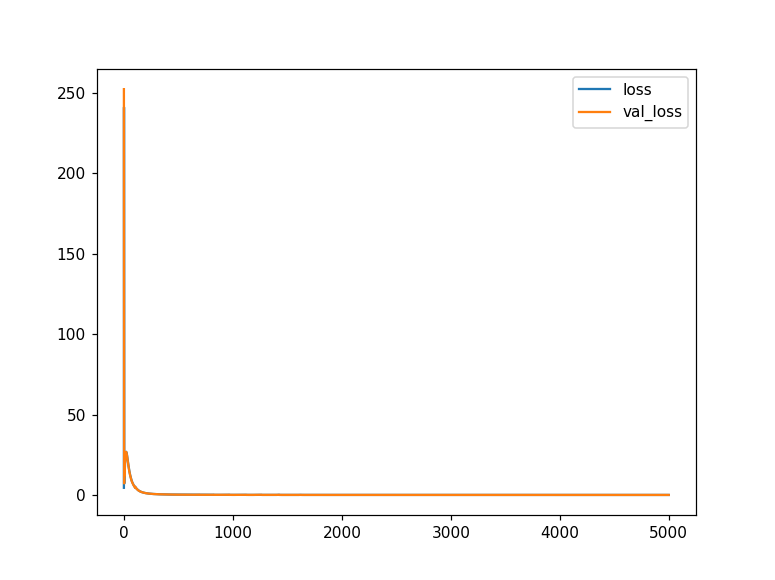

In [11]:
plt.figure()
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()
plt.show()
#plt.savefig('loss.jpg')

In [12]:
model.load_weights(checkpoint_save_path)
y_train_predict_scaled = model.predict(x_train)
y_train_predict_scaled = np.array(y_train_predict_scaled).flatten()
y_test_predict_scaled = model.predict(x_test)
y_test_predict_scaled = np.array(y_test_predict_scaled).flatten()
print(y_train.shape)
print(y_train_predict_scaled.shape)

(6257,)
(6257,)


In [13]:
y_train_invers = np.array(scaler.inverse_transform(y_train)).flatten()
y_test_invers = np.array(scaler.inverse_transform(y_test)).flatten()
y_train_predict_invers = np.array(scaler.inverse_transform(y_train_predict_scaled.reshape(-1,1))).flatten()#按scaler2回到原来参数
y_test_predict_invers  = np.array(scaler.inverse_transform(y_test_predict_scaled.reshape(-1,1))).flatten()
print(y_train_invers.shape,y_test_invers.shape,y_train_predict_invers.shape,y_test_predict_invers.shape)

(6257,) (1565,) (6257,) (1565,)


<IPython.core.display.Javascript object>


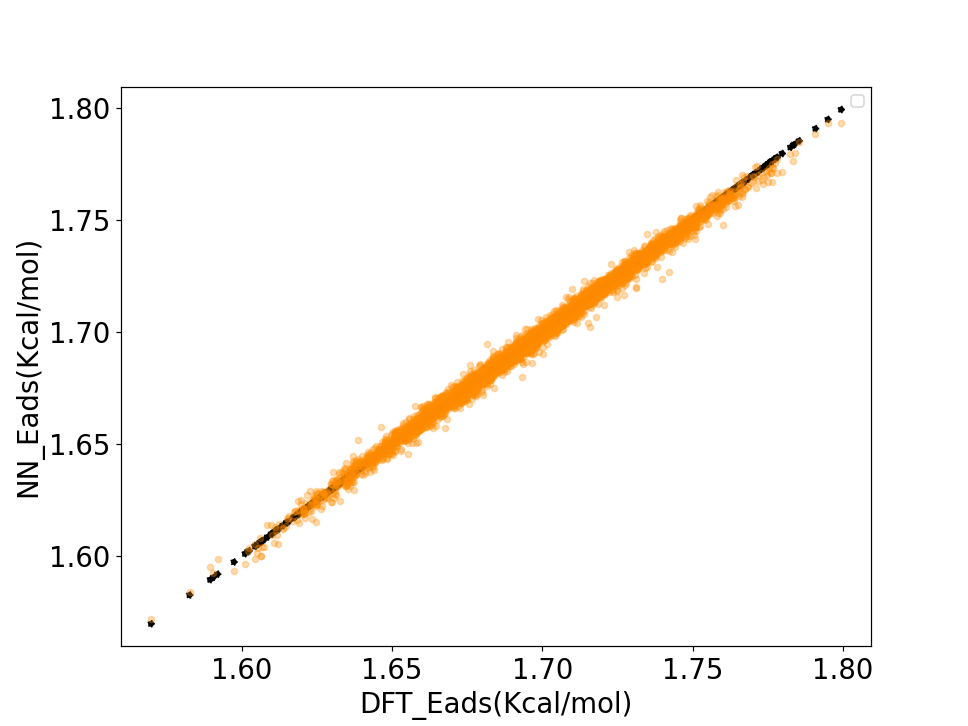

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [14]:
plt.figure(figsize=(8,6))
scale = 0.01
plt.xlim(min(y_train_invers)-scale,max(y_train_invers)+scale)
plt.ylim(min(y_train_invers)-scale,max(y_train_invers)+scale)

plt.scatter(y_train_invers,y_train_invers, color='black', s=16,linestyle='dotted')
plt.scatter(y_train_invers, y_train_predict_invers, s=16, alpha=0.3,color='darkorange')

plt.xlabel('DFT_Eads(Kcal/mol)',fontsize=18)
plt.ylabel('NN_Eads(Kcal/mol)',fontsize=18)

x1 = np.arange(min(y_train_invers),max(y_train_invers),0.5)
# plt.plot(x1,x1-3.6,label='y=x-3.6')
plt.legend()

plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
plt.legend()
plt.savefig('./Fe-C-O/Train.png')

<IPython.core.display.Javascript object>


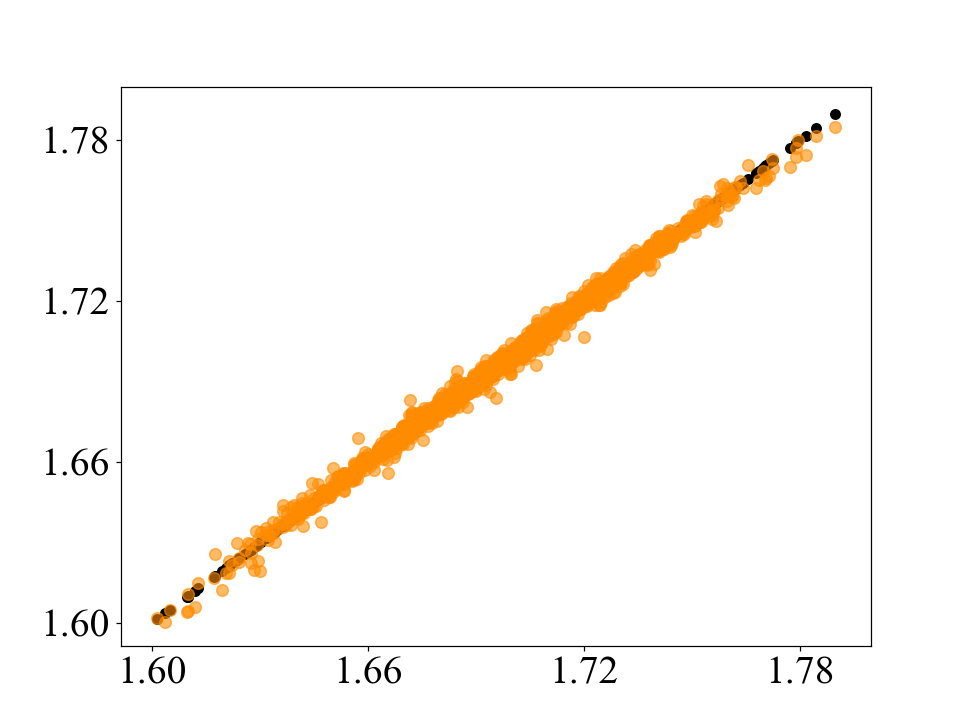

In [15]:
plt.figure(num=3,figsize=(8,6))
plt.rc('font',family='Times New Roman') 
scale = 0.01
plt.xlim(min(y_test_invers)-scale,max(y_test_invers)+scale)
plt.ylim(min(y_test_invers)-scale,max(y_test_invers)+scale)


plt.scatter(y_test_invers,y_test_invers, color='black', s=38
#             ,linestyle='dotted'
           )
plt.scatter(y_test_invers,y_test_predict_invers, s=58, alpha=0.6,color='darkorange')

# plt.xlabel('DFT',fontsize=24)
# plt.ylabel('NN',fontsize=24)

plt.xticks(np.arange(1.60,1.80,0.06),fontsize=26,rotation=0)
plt.yticks(np.arange(1.60,1.80,0.06),fontsize=26)

plt.savefig('./Fe-C-O/Test.png', dpi=168, bbox_inches='tight')

In [16]:
import sklearn.metrics as sm
print("训练集------MAE: ",sm.mean_absolute_error(y_train_invers,y_train_predict_invers))
print("测试集------MAE: ",sm.mean_absolute_error(y_test_invers,y_test_predict_invers))
print("训练集------MSE: ",sm.mean_squared_error(y_train_invers,y_train_predict_invers))
print("测试集------MSE: ",sm.mean_squared_error(y_test_invers,y_test_predict_invers))
print("训练集------RMSE: ",np.sqrt(sm.mean_squared_error(y_train_invers,y_train_predict_invers)))
print("测试集------RMSE:: ",np.sqrt(sm.mean_squared_error(y_test_invers,y_test_predict_invers)))
print("训练集------R2_score: ",sm.r2_score(y_train_invers,y_train_predict_invers))
print("测试集------R2_score:: ",sm.r2_score(y_test_invers,y_test_predict_invers))

训练集------MAE:  0.0016756597674496157
测试集------MAE:  0.0016919590118993197
训练集------MSE:  5.108567998775686e-06
测试集------MSE:  5.328266172148373e-06
训练集------RMSE:  0.002260214148875209
测试集------RMSE::  0.0023083037434766624
训练集------R2_score:  0.9945650367295091
测试集------R2_score::  0.9945072982412557


In [17]:
import sklearn.metrics as sm
random_x_test = np.random.permutation(x_test) 
y_test_invers = np.array(scaler.inverse_transform(y_test)).flatten()
print(x_test[0,0])
train_mae = []
test_mae = []
for i in range(1):
    new_x_test = x_test.copy()   #如果直接用等号，那么new_data_sets和data_sets会指向同一个地址，改变一个另一个也变
    new_x_test[:,i] = random_x_test[:,i]
    
    y_test_predict_scaled = model.predict(new_x_test)
    y_test_predict_scaled = np.array(y_test_predict_scaled).flatten()
    y_test_predict_invers  = np.array(scaler.inverse_transform(y_test_predict_scaled.reshape(-1,1))).flatten()#按scaler2回到原来参数
    mae = sm.mean_absolute_error(y_test_invers,y_test_predict_invers)
    test_mae.append(mae)
    
y_test_predict_scaled = model.predict(x_test)
y_test_predict_scaled = np.array(y_test_predict_scaled).flatten()
y_test_predict_invers  = np.array(scaler.inverse_transform(y_test_predict_scaled.reshape(-1,1))).flatten()#按scaler2回到原来参数
mae = sm.mean_absolute_error(y_test_invers,y_test_predict_invers)

print(x_test[0,0])
test_mae.append(mae)
print(len(test_mae),test_mae)

0.06675638550406471
0.06675638550406471
2 [0.004291589233364311, 0.0016919590118993197]
